# Truth Social Posts - Topic Modeling Analysis

This notebook analyzes Truth Social posts using topic modeling to discover and group posts by themes/topics. We'll use:
- **LDA (Latent Dirichlet Allocation)**: Traditional topic modeling
- **BERTopic**: Modern neural topic modeling 
- **Text preprocessing**: Cleaning and preparing text data
- **Visualization**: Interactive topic exploration

---


## Setup and Data Loading

First, let's import necessary libraries and load our data.


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string
from collections import Counter

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

# Scikit-learn for traditional topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pio.templates.default = "plotly_white"

print("📚 Libraries loaded successfully!")


📚 Libraries loaded successfully!


In [40]:
# Download required NLTK data
nltk_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words']

for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"Could not download {item}")

print("📥 NLTK data downloaded!")


📥 NLTK data downloaded!


In [41]:
# Load the Truth Social posts data
print("📊 Loading Truth Social posts data...")

df = pd.read_csv('../data/truth_social_posts_final_2025_cleaned.csv')
df['date_parsed'] = pd.to_datetime(df['date_parsed'])

print(f"✅ Loaded {len(df):,} posts")
print(f"📅 Date range: {df['date_parsed'].min()} to {df['date_parsed'].max()}")

# Check text content
text_posts = df[df['content_text'].notna() & (df['content_text'].str.len() > 0)]
print(f"📝 Posts with text content: {len(text_posts):,} ({len(text_posts)/len(df)*100:.1f}%)")

df.head()


📊 Loading Truth Social posts data...
✅ Loaded 3,477 posts
📅 Date range: 2025-01-01 10:48:00 to 2025-07-20 20:53:00
📝 Posts with text content: 1,885 (54.2%)


,speaker,handle,platform,post_url,content_text,image_url,deleted_flag,content_links,date_parsed,is_retweet,is_media_only
0,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:53:00,False,False
1,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,NaN,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:16:00,True,False
2,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,False,False
3,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,NaN,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,True,False
4,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:56:00,False,False


## Text Preprocessing

Let's clean and prepare the text data for topic modeling.


In [42]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
        # Add custom stop words for social media / Truth Social
        custom_stops = {
            'rt', 'retweet', 'truth', 'social', 'truthsocial', 'realdonaldtrump',
            'trump', 'donald', 'president', 'america', 'american', 'great',
            'make', 'people', 'country', 'united', 'states', 'usa', 'us',
            'amp', 'http', 'https', 'www', 'com', 'url', 'link'
        }
        self.stop_words.update(custom_stops)
    
    def clean_text(self, text):
        """Clean individual text"""
        if pd.isna(text) or text == '':
            return ''
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove mentions and hashtags (keep the text part)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove punctuation and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        if not text or text == '':
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stop words and short words
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]
        
        # Lemmatize
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return tokens
    
    def preprocess_documents(self, texts):
        """Preprocess a list of documents"""
        cleaned_docs = []
        
        for text in texts:
            # Clean text
            clean_text = self.clean_text(text)
            
            # Tokenize and lemmatize
            tokens = self.tokenize_and_lemmatize(clean_text)
            
            # Join back to string for vectorization
            processed_text = ' '.join(tokens)
            
            cleaned_docs.append(processed_text)
        
        return cleaned_docs

# Initialize preprocessor
preprocessor = TextPreprocessor()
print("🔧 Text preprocessor initialized!")


🔧 Text preprocessor initialized!


In [43]:
# Filter and preprocess text posts
print("🧹 Preprocessing text data...")

# Filter posts with meaningful text content
text_df = df[df['content_text'].notna() & (df['content_text'].str.len() > 10)].copy()

print(f"📊 Posts with sufficient text: {len(text_df):,}")

# Preprocess texts
text_df['processed_text'] = preprocessor.preprocess_documents(text_df['content_text'])

# Filter out very short processed texts
text_df = text_df[text_df['processed_text'].str.len() > 5]

print(f"📝 Final dataset size: {len(text_df):,} posts")

# Show examples
print("\n📋 Text preprocessing examples:")
for i in range(3):
    if i < len(text_df):
        original = text_df['content_text'].iloc[i][:100] + "..."
        processed = text_df['processed_text'].iloc[i][:100] + "..."
        print(f"\nOriginal: {original}")
        print(f"Processed: {processed}")

text_df.head()


🧹 Preprocessing text data...
📊 Posts with sufficient text: 1,878
📝 Final dataset size: 1,817 posts

📋 Text preprocessing examples:

Original: Adam “Shifty” Schiff is in BIG TROUBLE! He falsified Loan Documents. He once said my son would go to...
Processed: adam shifty schiff big trouble falsified loan document said son would prison scam schiff along crook...

Original: Go get the GREAT NEW BOOK by Mark Levin. It’s entitled “ON POWER,” and it’s the talk of the town. Re...
Processed: get new book mark levin entitled power talk town read digest enjoy truly one kind djt...

Original: HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???...
Processed: samantha power money...


,speaker,handle,platform,post_url,content_text,image_url,deleted_flag,content_links,date_parsed,is_retweet,is_media_only,processed_text
0,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:53:00,False,False,adam shifty schiff big trouble falsified loan ...
2,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,False,False,get new book mark levin entitled power talk to...
4,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:56:00,False,False,samantha power money
6,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Watch Mark Levin on FoxNews! NOW!!!,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:53:00,False,False,watch mark levin foxnews
15,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,“Greatest Bitcoin explanation of all time”,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 18:50:00,False,False,greatest bitcoin explanation time


## Exploratory Text Analysis

Let's explore the text data before topic modeling.


In [44]:
# Text statistics
print("📊 TEXT STATISTICS:")
print(f"   Total documents: {len(text_df):,}")
print(f"   Average text length (original): {text_df['content_text'].str.len().mean():.1f} characters")
print(f"   Average text length (processed): {text_df['processed_text'].str.len().mean():.1f} characters")

# Word frequency analysis
all_words = []
for text in text_df['processed_text']:
    all_words.extend(text.split())

word_freq = Counter(all_words)
print(f"   Vocabulary size: {len(word_freq):,} unique words")
print(f"   Total words: {len(all_words):,}")
print(f"   Average words per post: {len(all_words)/len(text_df):.1f}")

print("\n🔤 Most common words:")
for word, count in word_freq.most_common(20):
    print(f"   {word}: {count}")


📊 TEXT STATISTICS:
   Total documents: 1,817
   Average text length (original): 365.2 characters
   Average text length (processed): 221.6 characters
   Vocabulary size: 7,661 unique words
   Total words: 55,270
   Average words per post: 30.4

🔤 Most common words:
   one: 272
   would: 227
   get: 227
   never: 223
   year: 221
   time: 219
   big: 217
   job: 215
   many: 213
   first: 211
   new: 210
   border: 209
   tariff: 206
   day: 195
   world: 178
   thank: 178
   going: 166
   tax: 164
   like: 163
   let: 163


☁️ Creating word cloud...


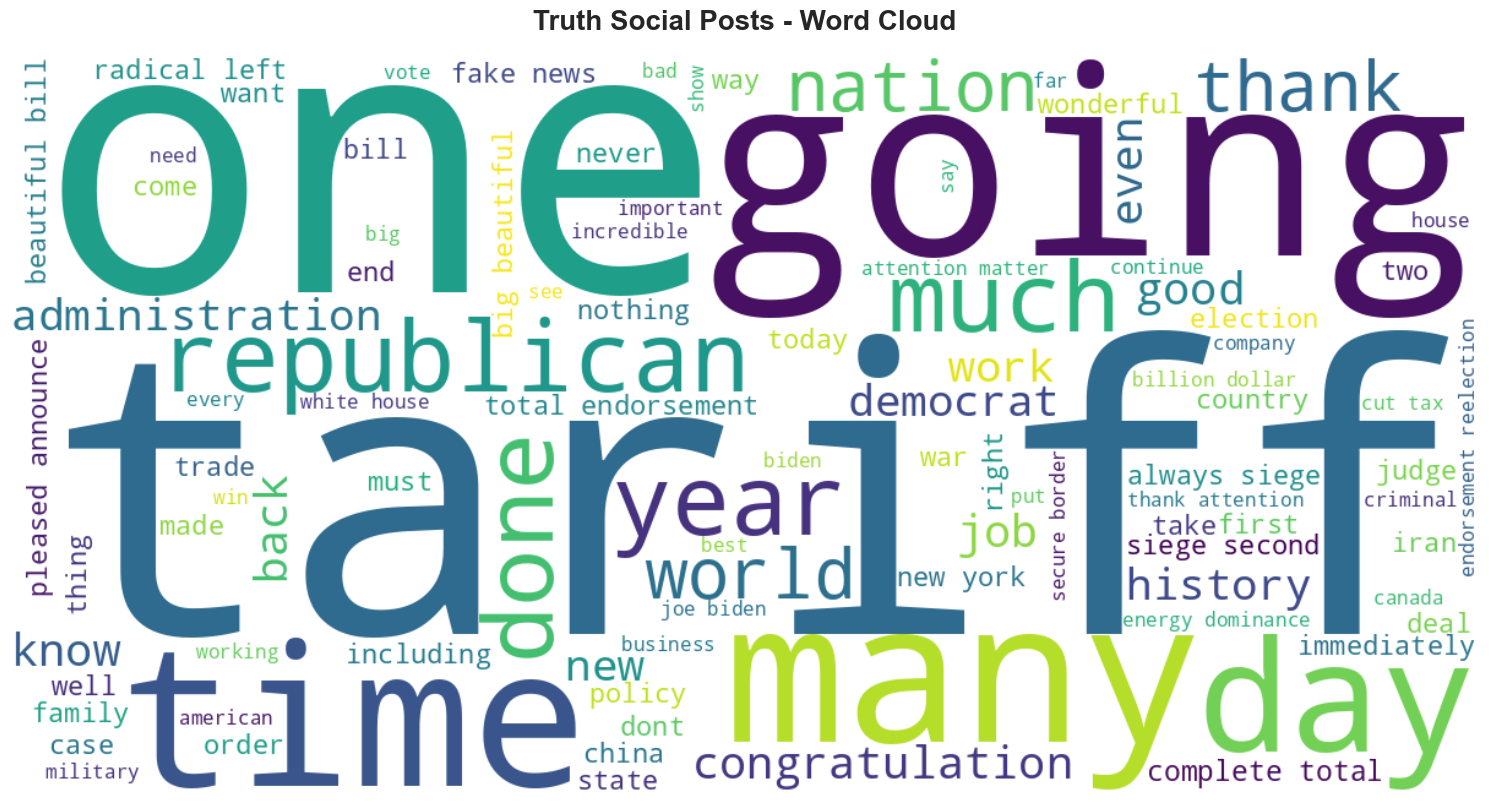

In [45]:
# Create word cloud
print("☁️ Creating word cloud...")

# Combine all processed text
all_text = ' '.join(text_df['processed_text'])

# Create word cloud
wordcloud = WordCloud(width=1200, height=600, 
                     background_color='white',
                     max_words=100,
                     colormap='viridis').generate(all_text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Truth Social Posts - Word Cloud', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../images/topic_wordcloud.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


## LDA Topic Modeling

Let's apply Latent Dirichlet Allocation (LDA) for topic discovery.


In [46]:
# Prepare data for LDA
print("🔍 Preparing data for LDA topic modeling...")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Top 1000 features
    min_df=5,          # Word must appear in at least 5 documents
    max_df=0.8,        # Word must appear in less than 80% of documents
    ngram_range=(1, 2), # Unigrams and bigrams
    stop_words='english'
)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(text_df['processed_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"📝 Features: {len(feature_names)} terms")

# Also create count vectorizer for LDA (works better with raw counts)
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english'
)

count_matrix = count_vectorizer.fit_transform(text_df['processed_text'])
count_feature_names = count_vectorizer.get_feature_names_out()

print(f"✅ Count matrix shape: {count_matrix.shape}")


🔍 Preparing data for LDA topic modeling...
✅ TF-IDF matrix shape: (1817, 1000)
📝 Features: 1000 terms
✅ Count matrix shape: (1817, 1000)


🔍 Finding optimal number of topics...
   Testing 2 topics... Perplexity: 673.44
   Testing 3 topics... Perplexity: 646.61
   Testing 4 topics... Perplexity: 617.16
   Testing 5 topics... Perplexity: 604.87
   Testing 6 topics... Perplexity: 603.71
   Testing 7 topics... Perplexity: 605.31
   Testing 8 topics... Perplexity: 588.71
   Testing 9 topics... Perplexity: 599.84
   Testing 10 topics... Perplexity: 590.08
   Testing 11 topics... Perplexity: 589.65
   Testing 12 topics... Perplexity: 587.32
   Testing 13 topics... Perplexity: 596.89
   Testing 14 topics... Perplexity: 583.65
   Testing 15 topics... Perplexity: 593.31


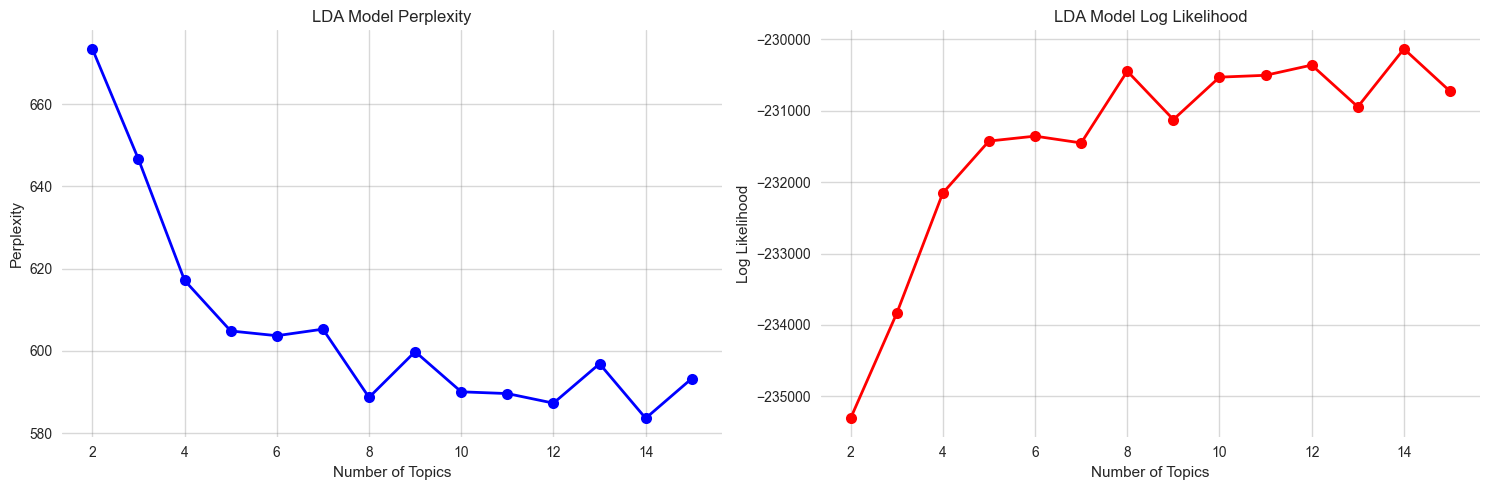

In [47]:
# Function to find optimal number of topics
def find_optimal_topics(count_matrix, max_topics=15):
    """Find optimal number of topics using perplexity"""
    perplexities = []
    log_likelihoods = []
    topic_range = range(2, max_topics + 1)
    
    print("🔍 Finding optimal number of topics...")
    
    for n_topics in topic_range:
        print(f"   Testing {n_topics} topics...", end=' ')
        
        # Train LDA model
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            n_jobs=-1
        )
        
        lda.fit(count_matrix)
        
        # Calculate metrics
        perplexity = lda.perplexity(count_matrix)
        log_likelihood = lda.score(count_matrix)
        
        perplexities.append(perplexity)
        log_likelihoods.append(log_likelihood)
        
        print(f"Perplexity: {perplexity:.2f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Perplexity plot
    ax1.plot(topic_range, perplexities, 'bo-', linewidth=2, markersize=8)
    ax1.set_facecolor('none')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Perplexity')
    ax1.set_title('LDA Model Perplexity')
    ax1.grid(True, color='gray', alpha=0.3)
    
    # Log-likelihood plot
    ax2.plot(topic_range, log_likelihoods, 'ro-', linewidth=2, markersize=8)
    ax2.set_facecolor('none')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Log Likelihood')
    ax2.set_title('LDA Model Log Likelihood')
    ax2.grid(True, color='gray', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../images/lda_model_selection.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    
    return topic_range, perplexities, log_likelihoods

# Find optimal topics
topic_range, perplexities, log_likelihoods = find_optimal_topics(count_matrix)


In [48]:
# Train final LDA model with optimal number of topics
# Based on the plots, choose number of topics (typically where perplexity starts to level off)
n_topics = 10  # Adjust based on the plots above

print(f"🎯 Training final LDA model with {n_topics} topics...")

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=200,
    learning_decay=0.7,
    learning_offset=50,
    n_jobs=-1
)

# Fit the model
lda_topics = lda_model.fit_transform(count_matrix)

print(f"✅ LDA training completed!")
print(f"📊 Document-topic matrix shape: {lda_topics.shape}")
print(f"🎯 Perplexity: {lda_model.perplexity(count_matrix):.2f}")
print(f"📈 Log-likelihood: {lda_model.score(count_matrix):.2f}")


🎯 Training final LDA model with 10 topics...
✅ LDA training completed!
📊 Document-topic matrix shape: (1817, 10)
🎯 Perplexity: 590.04
📈 Log-likelihood: -230528.88


In [49]:
# Extract and display topics
def display_topics(model, feature_names, no_top_words=10):
    """Display the top words for each topic"""
    topics = {}
    
    for topic_idx, topic in enumerate(model.components_):
        # Get top words for this topic
        top_words_idx = topic.argsort()[-no_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]
        
        topics[f"Topic {topic_idx + 1}"] = {
            'words': top_words,
            'weights': top_weights
        }
        
        print(f"\n🎯 Topic {topic_idx + 1}:")
        for word, weight in zip(top_words, top_weights):
            print(f"   {word}: {weight:.4f}")
    
    return topics

print("📋 LDA TOPICS:")
lda_topics_dict = display_topics(lda_model, count_feature_names)


📋 LDA TOPICS:

🎯 Topic 1:
   tariff: 206.0999
   canada: 72.0999
   country: 68.9646
   china: 64.7556
   world: 60.1332
   going: 55.9045
   business: 53.5239
   trade: 51.8111
   year: 50.8037
   day: 49.9852

🎯 Topic 2:
   dollar: 108.0762
   billion: 82.0999
   tax: 79.1797
   beautiful: 72.9114
   big: 69.1131
   cut: 67.0138
   billion dollar: 59.0999
   big beautiful: 54.0362
   rate: 49.6146
   law: 43.9687

🎯 Topic 3:
   war: 108.0999
   thank: 102.1360
   deal: 87.1050
   russia: 78.9069
   matter: 75.3046
   peace: 67.5111
   iran: 66.6186
   attention: 66.0999
   thank attention: 61.0999
   attention matter: 60.0999

🎯 Topic 4:
   secure: 137.4512
   energy: 103.8374
   complete: 102.9419
   complete total: 101.9432
   total: 98.7415
   endorsement: 98.0999
   border: 95.6699
   second: 91.8736
   total endorsement: 91.1000
   let: 84.3866

🎯 Topic 5:
   news: 135.5997
   fake: 131.0999
   new: 107.2780
   fake news: 81.1000
   york: 75.0999
   new york: 74.0999
   time: 70

In [50]:
# Assign dominant topic to each document
text_df['dominant_topic'] = lda_topics.argmax(axis=1)
text_df['topic_confidence'] = lda_topics.max(axis=1)

# Create topic names based on top words
topic_names = {}
for i in range(n_topics):
    top_3_words = lda_topics_dict[f"Topic {i+1}"]['words'][:3]
    topic_names[i] = f"Topic {i+1}: {'-'.join(top_3_words)}"

text_df['topic_name'] = text_df['dominant_topic'].map(topic_names)

print("📊 TOPIC DISTRIBUTION:")
topic_counts = text_df['dominant_topic'].value_counts().sort_index()
for topic_id, count in topic_counts.items():
    print(f"   {topic_names[topic_id]}: {count} posts ({count/len(text_df)*100:.1f}%)")

text_df[['content_text', 'dominant_topic', 'topic_name', 'topic_confidence']].head(10)


📊 TOPIC DISTRIBUTION:
   Topic 1: tariff-canada-country: 243 posts (13.4%)
   Topic 2: dollar-billion-tax: 160 posts (8.8%)
   Topic 3: war-thank-deal: 239 posts (13.2%)
   Topic 4: secure-energy-complete: 106 posts (5.8%)
   Topic 5: news-fake-new: 190 posts (10.5%)
   Topic 6: good-order-elon: 187 posts (10.3%)
   Topic 7: announce-pleased-pleased announce: 202 posts (11.1%)
   Topic 8: house-white-white house: 174 posts (9.6%)
   Topic 9: biden-border-joe: 147 posts (8.1%)
   Topic 10: republican-democrat-judge: 169 posts (9.3%)


,content_text,dominant_topic,topic_name,topic_confidence
0,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,8,Topic 9: biden-border-joe,0.363033
2,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,4,Topic 5: news-fake-new,0.637996
4,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,4,Topic 5: news-fake-new,0.699954
6,Watch Mark Levin on FoxNews! NOW!!!,4,Topic 5: news-fake-new,0.419999
15,“Greatest Bitcoin explanation of all time”,4,Topic 5: news-fake-new,0.699972
20,The Wall Street Journal ran a typically untrut...,0,Topic 1: tariff-canada-country,0.509025
21,My statement on the Washington Redskins has to...,5,Topic 6: good-order-elon,0.771000
24,"Last night, in New York City, an incredible CB...",8,Topic 9: biden-border-joe,0.542400
25,Adam Schiff is a THIEF! He should be prosecute...,9,Topic 10: republican-democrat-judge,0.849990
26,"Congratulations to William J. Pulte, Chairman ...",6,Topic 7: announce-pleased-pleased announce,0.446803


## Topic Visualization

Let's create comprehensive visualizations of the discovered topics.


📊 Creating topic visualizations...


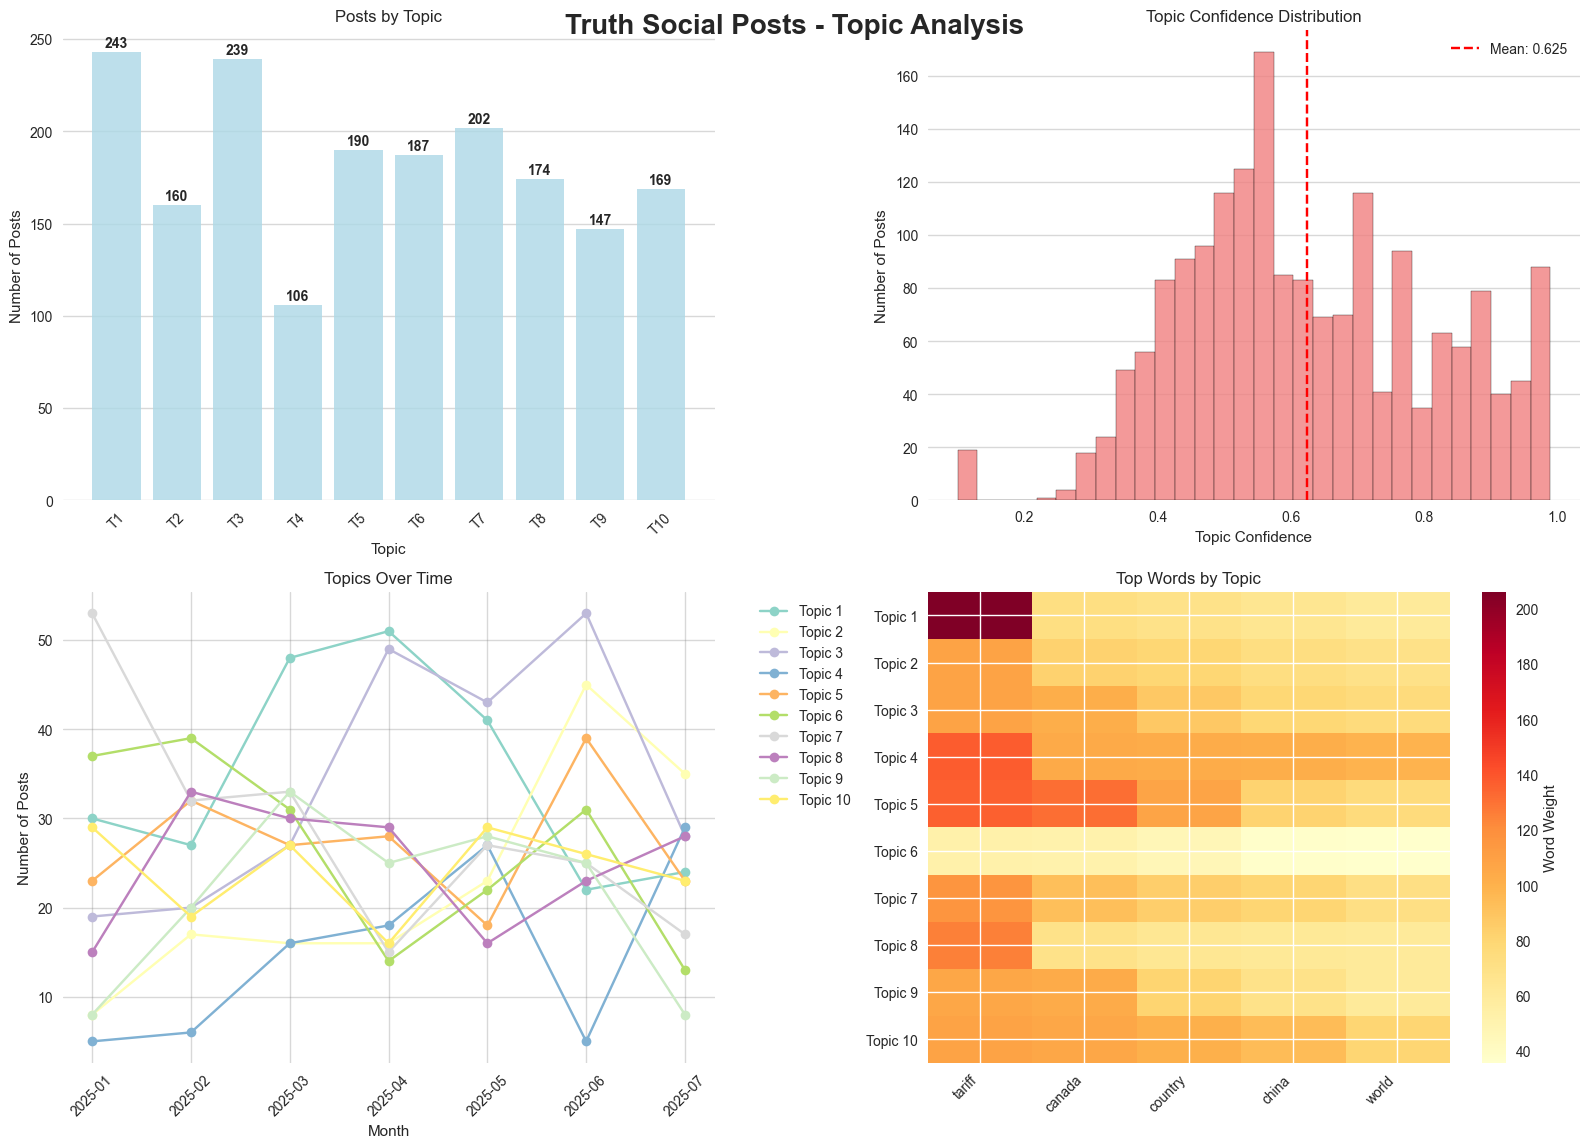

In [51]:
# Topic distribution visualization
print("📊 Creating topic visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Truth Social Posts - Topic Analysis', fontsize=20, fontweight='bold', y=0.95)

# 1. Topic Distribution
topic_counts = text_df['dominant_topic'].value_counts().sort_index()
topic_labels = [topic_names[i] for i in topic_counts.index]

bars = axes[0, 0].bar(range(len(topic_counts)), topic_counts.values, color='lightblue', alpha=0.8)
axes[0, 0].set_facecolor('none')
axes[0, 0].set_xlabel('Topic')
axes[0, 0].set_ylabel('Number of Posts')
axes[0, 0].set_title('Posts by Topic')
axes[0, 0].set_xticks(range(len(topic_counts)))
axes[0, 0].set_xticklabels([f'T{i+1}' for i in topic_counts.index], rotation=45)
axes[0, 0].grid(axis='y', color='gray', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 2. Topic Confidence Distribution
axes[0, 1].hist(text_df['topic_confidence'], bins=30, color='lightcoral', alpha=0.8, edgecolor='black')
axes[0, 1].set_facecolor('none')
axes[0, 1].set_xlabel('Topic Confidence')
axes[0, 1].set_ylabel('Number of Posts')
axes[0, 1].set_title('Topic Confidence Distribution')
axes[0, 1].grid(axis='y', color='gray', alpha=0.3)
axes[0, 1].axvline(text_df['topic_confidence'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {text_df["topic_confidence"].mean():.3f}')
axes[0, 1].legend()

# 3. Topics Over Time
text_df['month'] = text_df['date_parsed'].dt.to_period('M')
topic_time = text_df.groupby(['month', 'dominant_topic']).size().unstack(fill_value=0)

colors = plt.cm.Set3(np.linspace(0, 1, n_topics))
for i, topic_id in enumerate(topic_time.columns):
    axes[1, 0].plot(topic_time.index.astype(str), topic_time[topic_id], 
                   marker='o', label=f'Topic {topic_id + 1}', color=colors[i])

axes[1, 0].set_facecolor('none')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Posts')
axes[1, 0].set_title('Topics Over Time')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, color='gray', alpha=0.3)

# 4. Topic Word Importance Heatmap
top_words_per_topic = 5
word_topic_matrix = []
word_labels = []

for topic_id in range(n_topics):
    topic_words = lda_topics_dict[f"Topic {topic_id + 1}"]['words'][:top_words_per_topic]
    topic_weights = lda_topics_dict[f"Topic {topic_id + 1}"]['weights'][:top_words_per_topic]
    
    if topic_id == 0:  # First topic, collect all words
        word_labels = topic_words
    
    word_topic_matrix.append(topic_weights)

im = axes[1, 1].imshow(word_topic_matrix, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_facecolor('none')
axes[1, 1].set_xticks(range(top_words_per_topic))
axes[1, 1].set_xticklabels(word_labels, rotation=45, ha='right')
axes[1, 1].set_yticks(range(n_topics))
axes[1, 1].set_yticklabels([f'Topic {i+1}' for i in range(n_topics)])
axes[1, 1].set_title('Top Words by Topic')

# Add colorbar
plt.colorbar(im, ax=axes[1, 1], label='Word Weight')

plt.tight_layout()
plt.savefig('../images/topic_analysis_overview.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


## Export Topic Results

Let's save the topic modeling results for further analysis.


In [52]:
# Prepare export data
print("💾 Preparing topic modeling results for export...")

# Create comprehensive results dataframe
results_df = text_df[[
    'speaker', 'handle', 'platform', 'post_url', 'content_text', 
    'date_parsed', 'dominant_topic', 'topic_name', 'topic_confidence'
]].copy()

# Add topic probabilities for all topics
for i in range(n_topics):
    results_df[f'topic_{i+1}_prob'] = lda_topics[:, i]

# Add temporal features
results_df['hour'] = results_df['date_parsed'].dt.hour
results_df['day_of_week'] = results_df['date_parsed'].dt.day_name()
results_df['month'] = results_df['date_parsed'].dt.month
results_df['year_month'] = results_df['date_parsed'].dt.to_period('M')

print(f"✅ Results dataframe created with {len(results_df)} posts and {len(results_df.columns)} columns")

# Save to CSV
results_df.to_csv('../data/truth_social_posts_with_topics.csv', index=False)
print("💾 Results saved to '../data/truth_social_posts_with_topics.csv'")

# Create topic summary
topic_summary = {
    'model_info': {
        'algorithm': 'LDA (Latent Dirichlet Allocation)',
        'n_topics': n_topics,
        'n_documents': len(text_df),
        'n_features': len(count_feature_names),
        'perplexity': lda_model.perplexity(count_matrix),
        'log_likelihood': lda_model.score(count_matrix)
    },
    'topics': {}
}

for i in range(n_topics):
    topic_count = topic_counts[i] if i in topic_counts else 0
    topic_pct = (topic_count / len(text_df) * 100) if len(text_df) > 0 else 0
    
    topic_summary['topics'][f'topic_{i+1}'] = {
        'id': i,
        'name': topic_names[i],
        'num_posts': int(topic_count),
        'percentage': float(topic_pct),
        'top_words': lda_topics_dict[f"Topic {i+1}"]['words'][:10],
        'word_weights': [float(w) for w in lda_topics_dict[f"Topic {i+1}"]['weights'][:10]]
    }

# Save topic summary as JSON
import json
with open('../data/topic_modeling_summary.json', 'w') as f:
    json.dump(topic_summary, f, indent=2, default=str)

print("💾 Topic summary saved to '../data/topic_modeling_summary.json'")

results_df.head()


💾 Preparing topic modeling results for export...
✅ Results dataframe created with 1817 posts and 23 columns
💾 Results saved to '../data/truth_social_posts_with_topics.csv'
💾 Topic summary saved to '../data/topic_modeling_summary.json'


,speaker,handle,platform,post_url,content_text,date_parsed,dominant_topic,topic_name,topic_confidence,topic_1_prob,...,topic_5_prob,topic_6_prob,topic_7_prob,topic_8_prob,topic_9_prob,topic_10_prob,hour,day_of_week,month,year_month
0,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,2025-07-20 20:53:00,8,Topic 9: biden-border-joe,0.363033,0.224121,...,0.113687,0.004762,0.004762,0.004763,0.363033,0.270586,20,Sunday,7,2025-07
2,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,2025-07-20 20:06:00,4,Topic 5: news-fake-new,0.637996,0.009091,...,0.637996,0.009093,0.289263,0.009094,0.009091,0.009095,20,Sunday,7,2025-07
4,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,2025-07-20 19:56:00,4,Topic 5: news-fake-new,0.699954,0.033339,...,0.699954,0.033340,0.033333,0.033341,0.033339,0.033340,19,Sunday,7,2025-07
6,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Watch Mark Levin on FoxNews! NOW!!!,2025-07-20 19:53:00,4,Topic 5: news-fake-new,0.419999,0.020000,...,0.419999,0.020003,0.419997,0.020000,0.020001,0.020000,19,Sunday,7,2025-07
15,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,“Greatest Bitcoin explanation of all time”,2025-07-20 18:50:00,4,Topic 5: news-fake-new,0.699972,0.033338,...,0.699972,0.033337,0.033334,0.033344,0.033334,0.033336,18,Sunday,7,2025-07


## Summary and Key Insights

Let's summarize the key findings from our topic modeling analysis.


In [53]:
# Generate comprehensive summary
print("\n" + "="*80)
print("📋 TOPIC MODELING ANALYSIS SUMMARY")
print("="*80)

# Model performance
print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   Algorithm: LDA (Latent Dirichlet Allocation)")
print(f"   Number of topics: {n_topics}")
print(f"   Documents analyzed: {len(text_df):,}")
print(f"   Vocabulary size: {len(count_feature_names):,} terms")
print(f"   Model perplexity: {lda_model.perplexity(count_matrix):.2f}")
print(f"   Log-likelihood: {lda_model.score(count_matrix):.2f}")

# Topic distribution
print(f"\n🎯 TOPIC DISTRIBUTION:")
for topic_id, count in topic_counts.items():
    percentage = count/len(text_df)*100
    print(f"   {topic_names[topic_id]}: {count} posts ({percentage:.1f}%)")

# Key insights
print(f"\n💡 KEY INSIGHTS:")

# Most dominant topic
if len(topic_counts) > 0:
    dominant_topic_id = topic_counts.idxmax()
    dominant_count = topic_counts.max()
    dominant_pct = dominant_count/len(text_df)*100
    print(f"   📈 Most common topic: {topic_names[dominant_topic_id]} ({dominant_pct:.1f}% of posts)")

# Average confidence
avg_confidence = text_df['topic_confidence'].mean()
print(f"   📊 Average topic confidence: {avg_confidence:.3f} (higher = more distinct topics)")

# Content insights
avg_text_length = text_df['content_text'].str.len().mean()
print(f"   📝 Average post length: {avg_text_length:.0f} characters")

print(f"\n🎉 TOPIC MODELING APPLICATIONS:")
print(f"   ✅ Content categorization: Posts automatically grouped by themes")
print(f"   ✅ Trend analysis: Track topic evolution over time")
print(f"   ✅ Content strategy: Understand what topics resonate most")
print(f"   ✅ Similarity analysis: Find related posts across topics")
print(f"   ✅ Recommendation: Suggest similar content based on topics")

print(f"\n📁 OUTPUT FILES GENERATED:")
print(f"   📊 truth_social_posts_with_topics.csv - Posts with topic assignments")
print(f"   📋 topic_modeling_summary.json - Detailed topic information")
print(f"   📈 Various SVG visualizations in ../images/")

print("\n" + "="*80)
print("🎉 Topic modeling analysis completed successfully!")
print("="*80)



📋 TOPIC MODELING ANALYSIS SUMMARY

🤖 MODEL PERFORMANCE:
   Algorithm: LDA (Latent Dirichlet Allocation)
   Number of topics: 10
   Documents analyzed: 1,817
   Vocabulary size: 1,000 terms
   Model perplexity: 590.04
   Log-likelihood: -230528.88

🎯 TOPIC DISTRIBUTION:
   Topic 1: tariff-canada-country: 243 posts (13.4%)
   Topic 2: dollar-billion-tax: 160 posts (8.8%)
   Topic 3: war-thank-deal: 239 posts (13.2%)
   Topic 4: secure-energy-complete: 106 posts (5.8%)
   Topic 5: news-fake-new: 190 posts (10.5%)
   Topic 6: good-order-elon: 187 posts (10.3%)
   Topic 7: announce-pleased-pleased announce: 202 posts (11.1%)
   Topic 8: house-white-white house: 174 posts (9.6%)
   Topic 9: biden-border-joe: 147 posts (8.1%)
   Topic 10: republican-democrat-judge: 169 posts (9.3%)

💡 KEY INSIGHTS:
   📈 Most common topic: Topic 1: tariff-canada-country (13.4% of posts)
   📊 Average topic confidence: 0.625 (higher = more distinct topics)
   📝 Average post length: 365 characters

🎉 TOPIC MODEL